In [3]:
'''This diagonalizes the Hamiltonian matrix for a hydrogen-like spin system and 
gives various useful ESR related plots and values. Scroll down past the functions
section to get to the bit of the program where you tell it what to do'''
################################################
import numpy as np
from scipy.constants import*
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from fractions import Fraction
from colour import Color
################################################
#Functions
#Write 1/2 integer as fraction
def h_int(n):
    fraction = str(int(n*2))+"/2"
    return (fraction)


#Coefficient when raising operator J+ is applied
def alpha(mz,J):
    alpha = (J*(J+1)-mz*(mz+1))**0.5
    return (alpha)

#Multiplicity of J
def M(J):
    M = int(2*J+1)
    return (M)

#Creates N dimensional identity matrix
def identity (N):

    I = np.zeros((N,N))
    for n in range (N):
        for m in range(N):
            if n==m:
                I[n,m] = 1
    return (I)
            
#Angular momentum operators for angular momentum J
def ang_mo_op(J):
    N=int(2*J+1)
    
    J_plus = np.zeros((N,N))
    J_minus = np.zeros((N,N))
    Jz = np.zeros((N,N))
    
    for n in range (N):
        for m in range(N):
            if n==m+1:
                J_plus[n,m] = alpha(J-n,J)
            if n==m-1:
                J_minus[n,m] = alpha(J-m,J)
            if n==m:
                Jz[n,m] = J-n
    
    Jx = 0.5*(J_plus+J_minus)
    Jy = -0.5*1j*(J_plus-J_minus)
    return (Jx,Jy,Jz)
    
#Electron and nuclear Zeeman terms
def Zeeman(gI,gS,B,Ixb,Iyb,Izb,Sxb,Syb,Szb):
    ub = physical_constants["Bohr magneton"][0]
    un = physical_constants["nuclear magneton"][0]
    H = un*gI*((Ixb*B[0]+Iyb*B[1]+Izb*B[2]))+ub*gS*(Sxb*B[0]+Syb*B[1]+Szb*B[2])
    return (H)

#Hyperfine coupling term    
def HFC(A,Ix,Iy,Iz,Sx,Sy,Sz):
    H = h*A*(prod_IS(Ix,Sx)+prod_IS(Iy,Sy)+prod_IS(Iz,Sz))
    return (H)

#Multiply compenents by identities to enlarge a 2x2 matrix Sx to dimension (2MI)x(2MI)
def enlarge_S(MI,Sx):
    A = (identity(MI)*Sx[0,0])
    B = (identity(MI)*Sx[0,1])
    C = (identity(MI)*Sx[1,0])
    D = (identity(MI)*Sx[1,1])
    Sxb = np.bmat('A,B;C,D')
    return (Sxb)
    
#Enlarges an MIxMI matrix Ix to (2MI)x(2MI)
def enlarge_I(Ix,MI):
    Ixb=np.bmat([[Ix,np.zeros((MI,MI))],[np.zeros((MI,MI)),Ix]])
    return (Ixb)
    
#Kronecker product of a 2x2 matrix Sx with an MIxMI matrix Ix
def prod_IS(Ix,Sx):
    A = (Ix*Sx[0,0])
    B = (Ix*Sx[0,1])
    C = (Ix*Sx[1,0])
    D = (Ix*Sx[1,1])
    IxSx = np.bmat('A,B;C,D')
    return (IxSx)
    
#Plot energy levels against B field (remember to call plt.show afterwards if you want to see it!)
def plot_E_B(I,B_sweep,E,save):
    
    colour1 = Color("black")
    colour2 = Color("#8c8c8c")
    sns.set_style("white")
    MI = M(I)
    top_colours = list(colour2.range_to(colour1,MI))
    bottom_colours = list(colour1.range_to(colour2,MI))
    for n in range(MI*2):
        if (n<MI):
            plt.plot (B_sweep,E[n],label = n, color = str(bottom_colours[n]))
        else:
            plt.plot (B_sweep,E[n],label = n, color = str(top_colours[n-MI]))
    plt.xlabel('B(T)')
    plt.ylabel('Frequency shift (GHz)')
    plt.title('Energy Levels, I='+str(Fraction(I)))
    #sns.despine()
    #plt.legend()
#     manager = plt.get_current_fig_manager()
#     manager.window.showMaximized()
    if save == True:
        plt.savefig('EB_Plot, I='+str(I)+'.pdf')
    plt.show()
    
#Calculate all eigenenergies as a function of B field
def calc_eigenenergies(I,J,Bmax,A,gI,gS,points = 1000):
    sns.set(font_scale=1.25)
    MI = M(I)
    H = []
    E = []
    B_sweep = []

    (Ix,Iy,Iz) = ang_mo_op(I)
    (Ixb,Iyb,Izb) = (enlarge_I(Ix,MI),enlarge_I(Iy,MI),enlarge_I(Iz,MI))
    
    (Sx,Sy,Sz) = ang_mo_op(J)
    (Sxb,Syb,Szb) = (enlarge_S(MI,Sx),enlarge_S(MI,Sy),enlarge_S(MI,Sz))

    
    for n in range(MI*2):
        E.append([])
    
    for n in range (points):
        B=[0,0,Bmax/points*n]
        B_sweep.append(B[2])
        H.append(HFC(A,Ix,Iy,Iz,Sx,Sy,Sz)+Zeeman(gI,gS,B,Ixb,Iyb,Izb,Sxb,Syb,Szb))
        #print (H)
        (eigval,eigvec)=(np.linalg.eig(H[n]))
        for n in range(MI*2):
            E[n].append(np.sort(np.real(eigval))[n]/h/1E9)
    return (B_sweep,E)
    
def get_clock(E,B, show = False):
    transition_counter = 0
    transitions = []
    transition_energies = []
    sns.set_style("white")
    #sns.set(font_scale=1.5)
    dE = []
    level0 = []
    level1 = []
    
    for j in range (len(E)):
        dE.append([])
        level0.append([])
        level1.append([])
        for i in range (len(E)):
            dE[j].append([])
            level0[j].append([])
            level1[j].append([])
            for n in range (len(E[0])):
                dE[j][i].append([])
                dE[j][i][n]=(E[i][n]-E[j][n])
                level0[j][i].append([])
                level1[j][i].append([])
                level0[j][i][n],level1[j][i][n]=E[i][n],E[j][n]
                                
    for j in range (len(E)):
        if (j>=len(E)/2):
            Fj=len(E)/4
            mFj =j-(3*len(E)/4-1)
            mIj = mFj-1/2
            mSj = 1/2
        else:    
            Fj=len(E)/4-1    
            mFj = -j+(len(E)/4-1)
            mIj = mFj+1/2
            mSj = -1/2
        if (j==len(E)/2-1):    
            Fj=len(E)/4    
            mFj = -j+(len(E)/4-1)
            
        #print (mFj)
        for i in range (len(E)):
            if (i>=len(E)/2):
                Fi=len(E)/4
                mFi =i-(3*len(E)/4-1)
                mIi = mFi-1/2
                mSi = 1/2
            else:
                Fi=len(E)/4-1
                mFi = -i+(len(E)/4-1)
                mIi = mFi+1/2
                mSi = -1/2
            if (i==len(E)/2-1):
                Fi=len(E)/4
                mFi = -i+(len(E)/4-1)
            
            dmF = mFi-mFj
            dF = Fi-Fj
            #print (mFi,mFj,(i+1)*(1+j))
            if (abs(dmF)==1 and dF==-1):
                transitions.append([j,i])
                peak = signal.argrelmin(np.array(dE[i][j]))
                #print (dE[i][j])
                transition_energies.append(dE[i][j])
                if (len(peak[0])!= 0 and show == True):
                    print ("Levels: ("+h_int(mSj)+","+h_int(mIj)+") -> ("+h_int(mSi)+","+h_int(mIi)+")\t Field = "+ str(round(B[peak[0][0]]*1000,2))+" mT\tTransition frequency = "+str(round(dE[i][j][peak[0][0]],6))+" GHz, i,j = %i,%i"%(i,j))
                    print (level1[i][j][peak[0][0]],level0[i][j][peak[0][0]] )
                    plt.plot((B[peak[0][0]], B[peak[0][0]]), (level1[i][j][peak[0][0]],level0[i][j][peak[0][0]]), '#e65c00')

    return(transitions, transition_energies)

def plot_transitions(B_sweep,E, transitions):    
    colour1 = Color("darkslateblue")
    colour2 = Color("orange")
    colours = list(colour2.range_to(colour1,len(transitions)))
    
    for ij in transitions:
        plt.plot (np.multiply(B_sweep,1000),np.subtract(E[ij[0]],E[ij[1]]), label = '|-1/2,%s> -> |+1/2,%s>'%(h_int(ij[0]),h_int(ij[1])),color = str(colours[transitions.index(ij)]))

        plt.title('ESR Transitions - Low field selection rules')
    plt.xlabel('Field (mT)')
    plt.ylabel('Frequency(GHz)')
    plt.show()    

def plot_gradient():
    df = np.subtract(np.subtract(E[11][0:9998],E[8][0:9998]),np.subtract(E[11][1:9999],E[8][1:9999]))/(Bmax/10000)
    delta = np.subtract(np.subtract(E[10],E[7]),np.subtract(E[11],E[8]))
    plt.plot(np.multiply(B_sweep[0:9998],1000),df)
    plt.legend(bbox_to_anchor=(0.35, 1))
    plt.title('df/dB for |1/2,-9/2> -> |-1/2,-5/2> transition ')
    plt.xlabel('Field (mT)')
    plt.ylabel('df/dB (GHz/T)')
    plt.show()
    
def get_E(B_sweep, E, B0, T, show = False):
    GND = E[0][np.abs(np.subtract(B_sweep,B0)).argmin()]
    kb = physical_constants["Boltzmann constant"][0]
    En = []
    Zn = []
    for n in range (MI*2):
        En.append(E[n][np.abs(np.subtract(B_sweep,B0)).argmin()]-GND)
        Zn.append(np.exp(-En[n]*h*1E9/(kb*T)))
        if show == True:
            print(En[n],np.exp(-En[n]*h*1E9/(kb*T)))
    return(En, Zn)

def plot_Probabilities(B_sweep, E, B0,Tmin=0,Tmax=0.2):
    Temp = np.linspace(Tmin,Tmax,1001)
    P = []
    for n in range (MI*2):
        P.append([])
    levels = np.linspace(0,2*MI-1,2*MI, dtype = int)
    for T in Temp:
        En, Zn = get_E(B_sweep, E, B0,T, False)
        Z = np.sum(Zn)
        for level in levels:
            P[level].append(Zn[level]/Z)
    
    print (np.shape(P))
    sns.set_style('white')
    
    colour1 = Color("darkslateblue")
    colour2 = Color("orange")
    colours = list(colour2.range_to(colour1,MI*2))
    
    for level in levels:
        plt.plot(np.multiply(Temp,1000),P[level], label = level, color = str(colours[level]))
        
    plt.title('Probabilities for electron to be in each level (GND = 0), %.1fmT'%(B0*1000))
    plt.xlabel('Temperature (mK)')
    plt.ylabel('P')
    #plt.legend()
    plt.show()
    
def plot_HFClock(I,J,Bmax,A,gI,gS):
    B_sweep,E = calc_eigenenergies(I,J,Bmax,A,gI,gS)
    transitions, TE = get_clock (E,B_sweep)
    
    dA = A *0.0001
    A = A+dA
    B_sweep,E = calc_eigenenergies(I,J,Bmax,A,gI,gS)
    transitions, TEprime = get_clock (E,B_sweep)
    delta_E = np.subtract(TE,TEprime)
    
    colour1 = Color("darkslateblue")
    colour2 = Color("orange")
    colours = list(colour2.range_to(colour1,len(transitions)))
    
    n=0
    for delta_E_i in delta_E:
        if not all(abs(i) >= 0.000001 for i in delta_E_i):
            plt.plot(np.multiply(B_sweep,1000),delta_E_i/(dA/1E9), label = transitions[n])
            #print (TE[n][np.argmin(delta_E_i**2)],B_sweep[np.argmin(delta_E_i**2)])
        n=n+1
        
    plt.legend(bbox_to_anchor=(1, 0.3))
    plt.title('Hyperfine clock transitions - low field selection rules')
    plt.xlabel('Field (mT)')
    plt.ylabel('df/dA')
    sns.set_style("white")
    plt.show()    

Levels: (1/2,-9/2) -> (-1/2,-5/2)	 Field = 188.08 mT	Transition frequency = 5.216823 GHz, i,j = 7,10
-3.3450521245021476 1.8717712849168677
Levels: (1/2,-7/2) -> (-1/2,-3/2)	 Field = 133.44 mT	Transition frequency = 6.374133 GHz, i,j = 6,11
-3.7697729198594785 2.6043605044908946
Levels: (1/2,-7/2) -> (-1/2,-7/2)	 Field = 188.16 mT	Transition frequency = 5.214203 GHz, i,j = 8,11
-2.598718385122889 2.6154850186026377
Levels: (1/2,-5/2) -> (-1/2,-1/2)	 Field = 79.84 mT	Transition frequency = 7.032797 GHz, i,j = 5,12
-4.0016112371625665 3.031185966374726
Levels: (1/2,-5/2) -> (-1/2,-5/2)	 Field = 133.52 mT	Transition frequency = 6.372275 GHz, i,j = 7,12
-3.3362391424458333 3.0360353663663227
Levels: (1/2,-3/2) -> (-1/2,1/2)	 Field = 26.56 mT	Transition frequency = 7.338685 GHz, i,j = 4,13
-4.075420971784507 3.2632639148940625
Levels: (1/2,-3/2) -> (-1/2,-3/2)	 Field = 79.96 mT	Transition frequency = 7.031685 GHz, i,j = 6,13
-3.7663693172575092 3.26531522959702
Levels: (1/2,-1/2) -> (-1/2,-

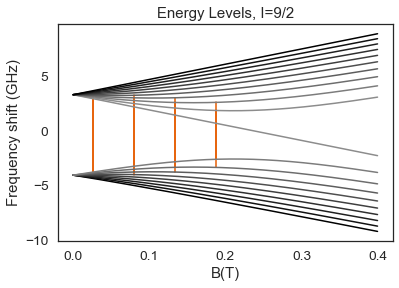

In [8]:
################################################
#Put spin system parameters here

I = 4.5                                                 #Nuclear spin I
J = 1/2                                                 #Electron total angular momentum (for now, this program only simulates J=S=1/2, L=0!)
MI = M(I)                                               #Multiplicity of nuclear spin
MJ = M(J)                                               #Multiplicity of electron angular momentum
gS = -2.00032                                           #Electron g factor
gI = 0.9135                                             #Nuclear g factor
A = 1475.17E6*1.0#140E6#3200E6#                             #Hyperfine coupling constant in Hz
Bmax = 0.4                                              #Max B field in Tesla

#################################################
#This is where you tell the program to do stuff

B_sweep,E = calc_eigenenergies(I,J,Bmax,A,gI,gS, points = 10000)        #Call this function first to get eigenenergies
transitions, transition_energies = get_clock(E, B_sweep, show = True)   #Gets clock transitions
plot_E_B (I,B_sweep,E,save = False)                                     #Plots Breit-Rabi Diagram
# plot_transitions(B_sweep,E, transitions)                                #Plots transition energies
# plot_Probabilities(B_sweep, E, B0=0.1334,Tmin=0,Tmax=0.2)               #Calculates partition function and plots probabilities
#plot_HFClock(I,J,Bmax,A,gI,gS)                                          #Plots Hyperfine clock transitions